In [10]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial.distance import squareform
import random

Create graph using different methods

In [56]:
#Create the Watts-Strogatz Graph

#Adding new edges
#nx.newman_watts_strogatz_graph(n, k, p, seed=None)

#The number of edges doesn't change
#nx.watts_strogatz_graph(n, k, p, seed=None)

#m is the number of edges
#nx.gnm_random_graph(n, m, seed=None, directed=False)
G = nx.watts_strogatz_graph(300, 6, 0.1, seed=None)


#Assign Random Weights to Edges
for (u, v) in G.edges():
    G.edges[u, v]['weight'] = np.random.uniform(0, 1)

Find the density and average clustering coefficients for the graph

In [57]:
print(nx.density(G))
nx.average_clustering(G, nodes=None, weight=None, count_zeros=True)

0.020066889632107024


0.42089153439153437

Plot the graph

Graph with 300 nodes and 900 edges


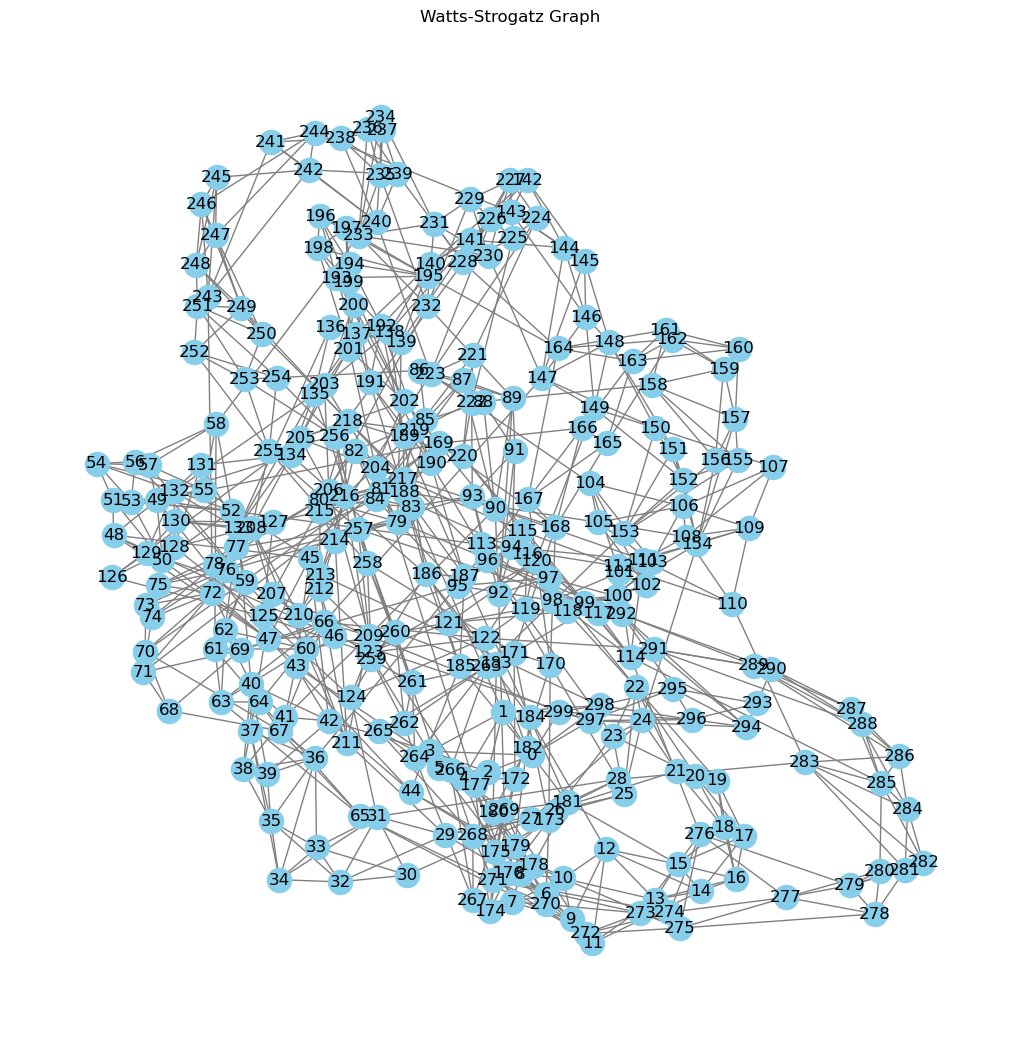

In [58]:
print(G)
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray')
plt.title("Watts-Strogatz Graph")
plt.show()

Persistent Homology

In [59]:
adj = nx.adjacency_matrix(G)
adj.setdiag(0)

res = ripser(adj, maxdim=2, distance_matrix=True)


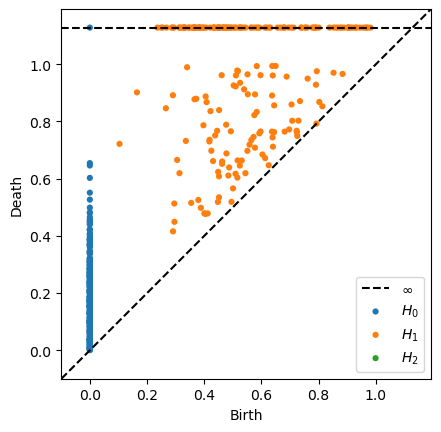

In [60]:
# Convert the Graph to a Distance Matrix
# We will use the Floyd-Warshall algorithm to compute the shortest path distance matrix
# dist_matrix = nx.floyd_warshall_numpy(G, weight='weight')
dist_matrix = nx.adjacency_matrix(G, weight='weight')

# Compute the Barcode Using Ripser
diagrams = ripser(dist_matrix, maxdim=2, distance_matrix=True)['dgms']

# Step 5: Plot the Barcode
plot_diagrams(diagrams, show=True)

In [61]:
def local_edge_swap(graph, k, num_swaps_per_node):
    # Make a copy of the original graph
    H = graph.copy()
    
    # Iterate through each node in the graph
    for node in H.nodes():
        # Get the k-neighborhood of the node
        k_neighborhood = nx.ego_graph(H, node, radius=k)
        
        # Get the edges within the k-neighborhood
        edges = list(k_neighborhood.edges())
        
        # Perform edge swaps within the k-neighborhood
        for _ in range(num_swaps_per_node):
            if len(edges) < 2:
                break
            # Choose two random edges to swap
            edge1, edge2 = random.sample(edges, 2)
            (u1, v1) = edge1
            (u2, v2) = edge2
            
            # Avoid creating self-loops or duplicate edges
            if len({u1, v1, u2, v2}) == 4:
                if not H.has_edge(u1, v2) and not H.has_edge(u2, v1):
                    # Perform the edge swap
                    H.remove_edge(u1, v1)
                    H.remove_edge(u2, v2)
                    H.add_edge(u1, v2)
                    H.add_edge(u2, v1)
                    # Update the edges list
                    edges.remove(edge1)
                    edges.remove(edge2)
                    edges.append((u1, v2))
                    edges.append((u2, v1))
                    
    return H


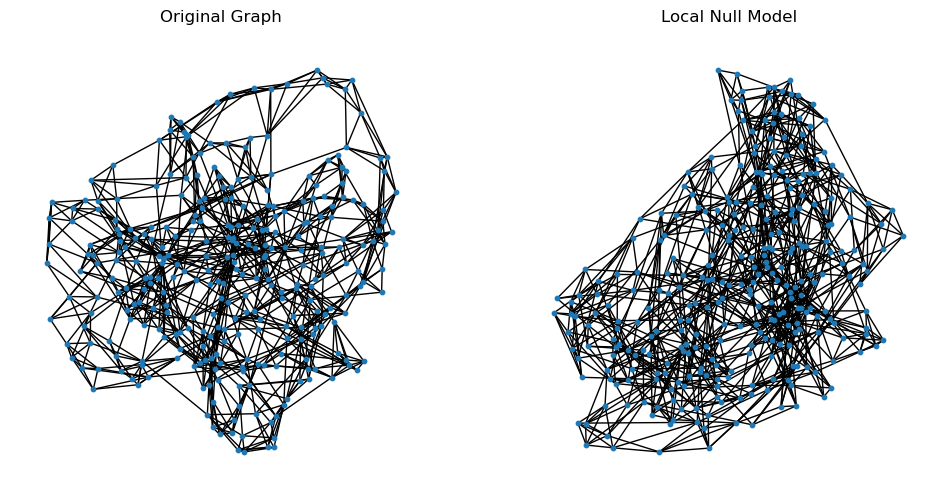

In [62]:
# Parameters
k = 2  # radius for k-neighborhood
num_swaps_per_node = 1  # number of swaps to perform per node's neighborhood

# Create the local null model
local_null_model = local_edge_swap(G, k, num_swaps_per_node)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

nx.draw(G, ax=axes[0], node_size=10)
axes[0].set_title('Original Graph')

nx.draw(local_null_model, ax=axes[1], node_size=10)
axes[1].set_title('Local Null Model')

plt.show()

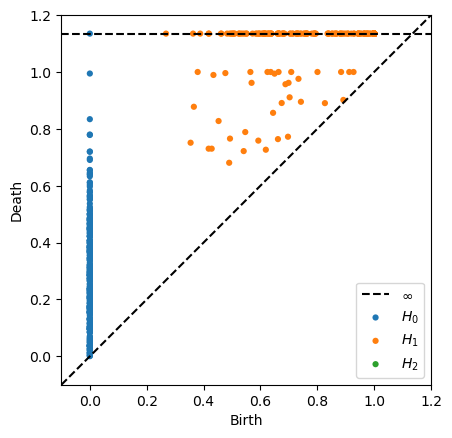

In [63]:
# dist_matrix = nx.floyd_warshall_numpy(local_null_model, weight='weight')
dist_matrix = nx.adjacency_matrix(local_null_model, weight='weight')

# Compute the Barcode Using Ripser
diagrams = ripser(dist_matrix, maxdim=2, distance_matrix=True)['dgms']

# Step 5: Plot the Barcode
plot_diagrams(diagrams, show=True)

In [64]:
import oatpy as oat
import pandas as pd

def persistance_image(barcode: pd.DataFrame,
                      dim: int | list[int] | None = None,
                      sigma: float = 0.1,
                      res: int = 20,
                      weight_func: callable = lambda x, y: y,
                      return_vec: bool = False
                      ) -> np.ndarray | dict[int: np.ndarray]:
    '''
    Makes a persitance image from a homology dataframe

    The coordinates for the peristance image are normalized within [0, 1]. The function
    treats features that never die as having a death coordiate of 1, so features that die
    in the last period aren't distingushed from features that never die. If you want to
    plot the perstance image, use
    ```
        import matplotlib.pyplot as plt

        x = np.linspace(0, 1, resolution)
        y = np.linspace(0, 1, resolution)
        x, y = np.meshgrid(x, y)
        res = persistance_image(
                homology,
                res=resolution,
                return_vec=False # return_vec defaults false, so you can leave it out, but not make it true
            )

        plt.axis('equal')
        plt.pcolormesh(x, y, res[dimension])
    ```

    Args:
        `barcode` (Dataframe): A dataframe with homological features of the simplicial
        complex. Should have a "birth" column for when features were born, a "death"
        column with when features died, and a "dimension" column with the feature
        dimension
        `dim` (int | list[int] | None): The dimensions to create a persistance image for.
        If an int, creates an image for only that dimension. If a list (or other iterable),
        creates an image for all the dimensions in the list. If None, creates an image for
        all unique dimensions in `barcode`.
        Default None.
        `sigma` (float): Standard deviation of the Gaussians used for the persistance
        image. Default 0.1
        `res` (int): Resolution of the returned peristance image. Default 20
        `weight_func` (callable): Function in f(x, y) form that takes the birth, lifetime
        coordinates of the feature and returns the weight of the feature in the gaussians.
        f(x, 0) should be 0 for all x values. Defaults to linear scaling based only on the
        lifetime 
        `return_vec` (bool): Whether to return an matrix or vector. If True, returns a
        vector. Typically, a matrix will work better to visualize the persistance image but
         a vector is better to compare two barcodes. Default False
    
    Returns:
        `persistance_images` (list[np.ndarray]): A list of matricies of vectors (depening on
        the return_vec value) with the peristance images. Each value in the list corresponds
        to a different dimension, with the ith value corresponding to the persistance image
        for i dimensional features
    '''
    # we want it in a list
    if isinstance(dim, int):
        dim = [dim]

    # maximum lifetime
    # we want to normalize everything to [0, 1], this is the value we divide by to do that
    max_lifetime = oat.barcode.max_finite_value(barcode['death'])

    # points on the persistance diagram
    persistance_diagram = pd.DataFrame()
    persistance_diagram['dimension'] = barcode.reset_index(drop=True)['dimension'] # Each unique dimension will be a different diagram
    persistance_diagram['birth'] = barcode.reset_index(drop=True)['birth'] / max_lifetime # normalize birth times
    persistance_diagram['death'] = barcode.reset_index(drop=True)['death'] / max_lifetime # normalize death times
    persistance_diagram.loc[persistance_diagram['death'] == np.inf, 'death'] = 1 # set inf death times to the max (1)
    persistance_diagram['lifetime'] = persistance_diagram['death'] - persistance_diagram['birth'] # birth, lifetime create persistance image basis
    persistance_diagram['weight'] = weight_func(persistance_diagram['birth'], persistance_diagram['lifetime'])

    # remove rows after max dimension
    if dim is not None:
        persistance_diagram = persistance_diagram[persistance_diagram['dimension'].isin(dim)]
    else:
        dim = list(persistance_diagram['dimension'].unique()) # loop over dim later, needs to be defined

    # matricies to calculate peristance image
    # x, y coordinate of every entry i, j in the persistance image is x[i, j], y[i, j]
    x = np.linspace(0, 1, res)
    y = np.linspace(0, 1, res)
    x, y = np.meshgrid(x, y)

    # apply gaussians and get images
    var = 2 * sigma**2 # actualy 2*variance but this is what we use so
    persistance_images = []
    for d in dim: # create a different persisance image for each dimension
        d_persistance_diagram = persistance_diagram[persistance_diagram['dimension'] == d] # peristance diagram fo dimension
        gaussians = [w * np.exp(-((x-b)**2 + (y-l)**2)/var) for w, b, l in zip(d_persistance_diagram['weight'], d_persistance_diagram['birth'], d_persistance_diagram['lifetime'])]
        # use gaussian formula weighting by the calculated weight and using the point location for all x and y in the matrix
        persistance_image = np.full((res, res), 0) + sum(gaussians) # full makes sure we have all 0s if dimension has no features
        persistance_images.append(persistance_image)
    
    # make a vector (if we should)
    if return_vec:
        persistance_images = [np.reshape(pi, -1) for pi in persistance_images]
    
    # reshape returned value
    if len(persistance_images) == 1: # take it out of the list if there's only one thing
        persistance_images = persistance_images[0]
    else: # make a dict with the dim values
        persistance_images = {d: pi for d, pi in zip(dim, persistance_images)}

    return persistance_images


def format_ripser_output(ripser_res: dict[str: np.ndarray]
                         ) -> pd.DataFrame:
    '''
    Takes the results from a ripser function and formats it as a dataframe
    to be used to compare to other barcodes.

    Args:
        `ripser_res` (dict[str: np.ndarray]): The results from the `ripser`
        function within the `ripser` library
    
    Returns:
        `res` (Dataframe): Formatted and sorted dataframe containing the
        barcode information in "dimension", "birth", and "death" columns
    '''
    dimension = [] # feature dimention
    birth = [] # birth time
    death = [] # death time

    for dim, bc in enumerate(ripser_res['dgms']):
        for b, d in bc:
            dimension.append(dim)
            birth.append(b)
            death.append(d)

    # collect results
    res = pd.DataFrame(data={'dimension': dimension, 'birth': birth, 'death': death})
    res = res.sort_values(['dimension', 'birth', 'death'], ignore_index=True)
    return res

In [65]:
dist_matrix_null = nx.adjacency_matrix(local_null_model, weight='weight')

# Compute the Barcode Using Ripser
null_res = ripser(dist_matrix_null, maxdim=2, distance_matrix=True)
null_res = format_ripser_output(null_res)

# Step 5: Plot the Barcode
null_pi = persistance_image(null_res, return_vec=True)

In [66]:
dist_matrix_G = nx.adjacency_matrix(G, weight='weight')

# Compute the Barcode Using Ripser
G_res = ripser(dist_matrix_G, maxdim=2, distance_matrix=True)
G_res = format_ripser_output(G_res)

# Step 5: Plot the Barcode
G_pi = persistance_image(G_res, return_vec=True)

In [67]:
dim = 1
p = 2

sum(np.abs(null_pi[dim] - G_pi[dim])**2)**(1/p)

99.61283556513135

In [68]:
G_res[G_res['dimension'] == 1]

,dimension,birth,death
300,1,0.103711,0.721745
301,1,0.164668,0.901733
302,1,0.236537,inf
303,1,0.249672,inf
304,1,0.254836,inf
...,...,...,...
514,1,0.956607,inf
515,1,0.965079,inf
516,1,0.965845,inf
517,1,0.971456,inf
